
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 991 картинка, для которых вам будет необходимо предсказать класс.

## Шаг 1. Установка зависимостей

####Установим необходимые библиотеки и проверим доступность CUDA

In [61]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [62]:
!nvidia-smi

Thu Nov 13 11:27:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             32W /   70W |   14085MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [63]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [64]:
!pip install pretrainedmodels

In [65]:
import pretrainedmodels

In [66]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

#### Проверим версии Python и библиотек
Посмотрим, какие версии установлены:

In [67]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.11.13
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.2
seaborn version: 0.12.2
Pillow version: 11.3.0


Сверим с версиями питона и библиотек, на которых работал эталонный ноутбук:

- Python 3.12.12
- torch version: 2.8.0+cu126
- torchvision version: 0.23.0+cu126
- tqdm version: 4.67.1
- matplotlib version: 3.10.0
- seaborn version: 0.13.2
- Pillow version: 11.3.0


 #### Определим константы, которые будем использовать в по ходу ноутбука

In [68]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/working/train') #Path('./data/train/')
TEST_DIR = Path('/kaggle/working/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

#### Скачаем изображения по ссылке

In [69]:
!gdown 1S1RhKLbAEyWGXeOJfUnQg3pT1FCKXSfw

In [70]:
!unzip -q /kaggle/working/journey-springfield.zip

Посмотрите на структуру файлов в папках train и testset.

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок. Это полные имена, включающие путь к файлам.


In [71]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа. Зададим числовые метки классов нашего энкодера при помощи метода `fit`.

Далее будем применять метод `transform` для преобразования текстовых меток в числовые, и метод `inverse_transform` для преобразования числовых меток в текстовые.


In [72]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса.

In [73]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

####Создадим Datasets и Dataloaders

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:
https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


У нас есть набор файлов-картинок, которые требуется преобразовать в тензоры, и добавить к ним числовые метки классов. Реализуем это с помощью созданного нами класса `SimpsonsDataset`, который из списка файлов создаст необходимый нам Dataset.  

Будем действовать согласно инструкции из документации (https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files):
- наш класс будет наследовать от класса Dataset
- мы переопределим методы `__init__`, `__len__` и `__getitem__`, а также для удобства добавим несколько методов для загрузки и преобразования изображений.

Важно разобраться, что делает метод self.transform_images_to_tensors().

`Compose` объединяет последовательность следующих преобразований:
- `PILToTensor` конвертирует  `PIL Image` в тензор с параметрами в диапазоне $[0, 255]$ (как все пиксели в исходном изображении)
- `ToDtype` преобразует тензор в `FloatTensor` размера ($C \times H \times W$) со значениями пикселей в диапазоне $[0,1]$
- затем `Normalize` производится масштабирование:
$\text{input} = \frac{\text{input} - \text{mean}}{\text{std}} $, <br>      где константы mean и std - средние и дисперсии по каналам в датасете ImageNet
- наконец, `Resize` преобразует картинки к размеру $224 \times 224$ (в описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру).

Сейчас аугментация не изображений не производится, поэтому для обучающих и валидационных/тестовых изображений производится одинаковая трансформация. В дальнейшем, если вы захотите добавить аугментацию, вы можете сделать это, например, модифицировав метод `transform_images_to_tensors`. Подробнее про трансформацию изображений вы можете почитать в документации: https://docs.pytorch.org/vision/main/transforms.html


In [74]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_ # сейчас self.__len__() возвращает количество картинок, подаваемых на вход.
        # Если вы решите перевзвесить размеры категорий внутри класса -
        # не забудьте изменить вывод self.__len__()

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            v2.Resize(RESCALE_SIZE),
          ])
      else:
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            v2.Resize(RESCALE_SIZE),
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [75]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [76]:
batch_size = 64

In [77]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

Напишем функцию для визуализации картинок. Это аналог Imshow, которая будет принимать на вход тензоры

In [78]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 7
Текстовая метка класса: ['chief_wiggum']


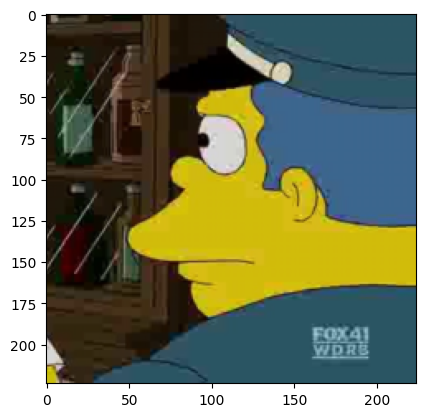

In [79]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [80]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [81]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам. Очистка датасета - это один из способов повысить качество модели. Этим можно будет заняться во второй части домашнего задания.

Запустим написанную функцию.

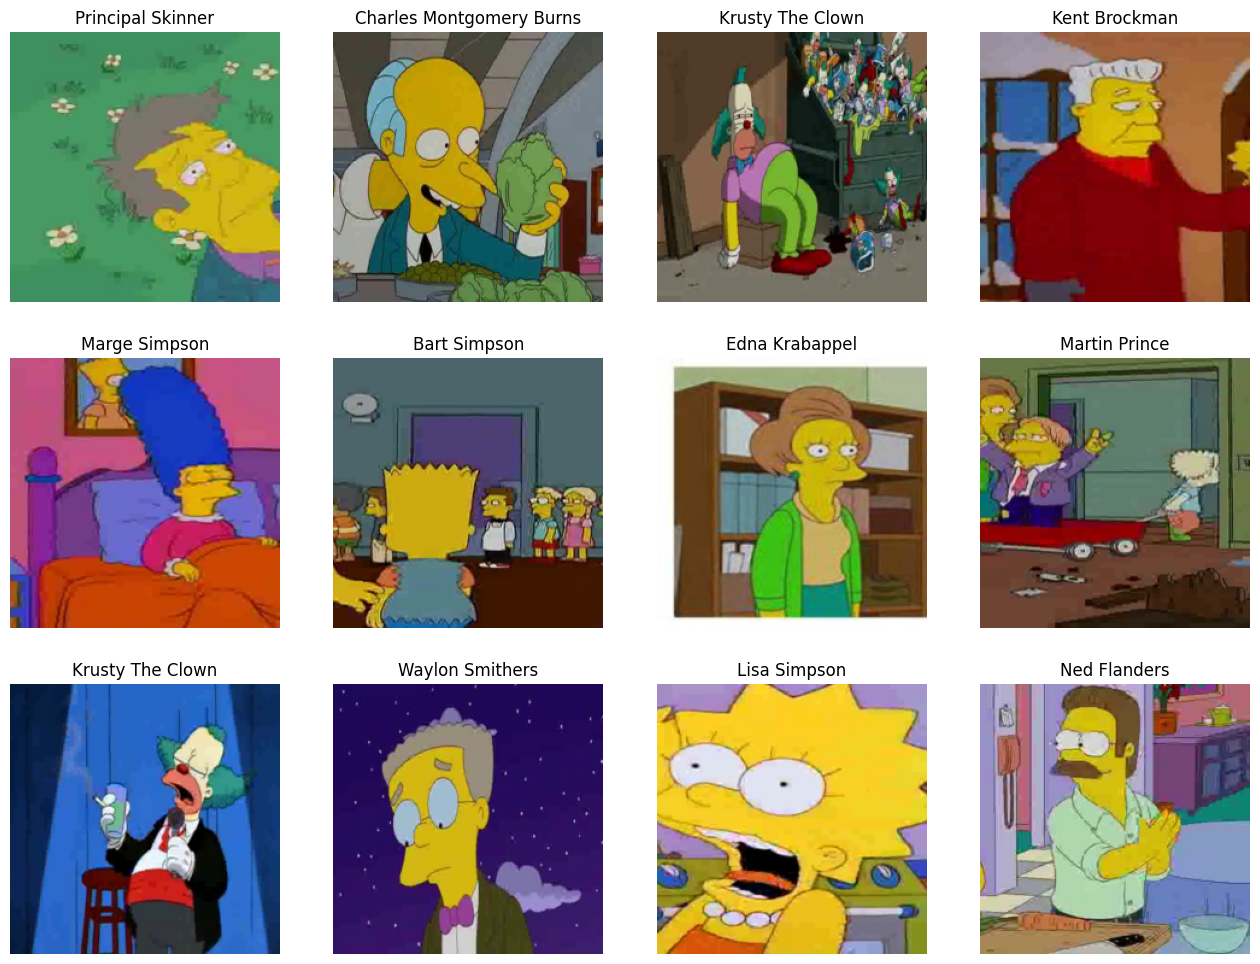

In [82]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

## Шаг 3. Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [83]:
class PretrainedModelWrapper(nn.Module):
    def __init__(self, model_name, n_classes):
        super().__init__()

        # Загружаем модель
        self.backbone = pretrainedmodels.__dict__[model_name](
            num_classes=1000,
            pretrained='imagenet'
        )

        # Замораживаем веса
        #for param in self.backbone.parameters():
        #    param.requires_grad = False

        if model_name == 'inceptionv4':
            # Заменяем финальный AveragePooling2d на AdaptiveAvgPool2d
            # Это решает проблему с размером 1536x5x5
            self.backbone.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

            # Заменяем последний линейный слой
            num_features = self.backbone.last_linear.in_features
            self.backbone.last_linear = nn.Linear(num_features, n_classes)
        elif model_name == 'inceptionresnetv2':
            # Для inceptionresnetv2 замена аналогичная
            # У этой модели pooling слой называется avgpool_1a
            self.backbone.avgpool_1a = nn.AdaptiveAvgPool2d((1, 1))

            # Заменяем последний линейный слой
            num_features = self.backbone.last_linear.in_features
            self.backbone.last_linear = nn.Linear(num_features, n_classes)

            # Заменяем последний линейный слой
            num_features = self.backbone.last_linear.in_features
            self.backbone.last_linear = nn.Linear(num_features, n_classes)
        else:
            # Для других моделей используем стандартный подход
            self._replace_last_layer(model_name, n_classes)

    def forward(self, x):
        return self.backbone(x)

In [84]:
model = PretrainedModelWrapper(n_classes = len(np.unique(train_val_labels)), model_name = 'inceptionresnetv2')
model.to(DEVICE)
#torchsummary.summary(model, (3, 224, 224))

PretrainedModelWrapper(
  (backbone): InceptionResNetV2(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, a

##Шаг 4. Функции для работы с моделью

#### Задание - напишите функции для работы с моделью

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Ниже приводится код для вычисления целевой метрики.

In [85]:
from sklearn.metrics import f1_score
# пример расчета: f1 = f1_score(actual_labels, y_predicted, average='micro')

В этом задании может быть полезным сделать, чтобы функция валидации и, возможно, функция обучения на одной эпохе возвращали векторы/тензоры:
- предсказанного наиболее вероятного класса
- и фактических меток класса для каждого объекта.

Сама метрика f1, при этом, будет вычисляться не внутри функции, а вне ее, сопоставляя прогнозные и фактические значения, полученные из вывода функции.

Это поможет проанализировать, при предсказании каких классов модель ошибается чаще. Также такой подход может использоваться для обнаружения изображений, которые модель классифицирует неверно.

Для ускорения вычислений рекомендуется при работе с моделью проводить тензорные вычисления на GPU. Обращаем внимание, для этого необходимо, чтобы и данные, и модель находились на одном устройстве.

Ниже представлен код из предыдущего домашнего задания, который демонстрировал логику циклов обучения и валидации. Ниже в этот код добавлены строки комментарии, показывающие как переносить модель и данные на устройство.


```python
model.to(DEVICE)  # <- переносим модель на устройство DEVICE

for epoch in range(max_epochs):  
    # режим train
    model.train()  
    for x_batch, y_batch in train_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        optimizer.zero_grad()
        outp = model(x_batch)
        loss = criterion(outp, y_batch)
        loss.backward()  
        optimizer.step()
        
        count_metrics(outp, y_batch)  # <-здесь, скорее всего, потребуется перенести данные на cpu, например с помощью метода cpu: metrics.cpu()
     
     # режим test/eval
     model.eval()  
     for x_batch, y_batch in val_dataloader:
        x_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        y_batch.to(DEVICE)  # <- переносим тензоры данных на устройство DEVICE
        
        with torch.no_grad():
            outp = model(x_batch)
            count_metrics(outp, y_batch) # <-здесь, скорее всего, потребуется перенести данные на cpu       
```

Напишите функции:
- для обучения модели на одной эпохе
- для валидации модели на одной эпохе
- для реализации полного цикла обучения

За основу можно взять функции, которые вы написали в предыдущем домашнем задании.

In [86]:
# YOUR CODE
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Обучение модели на одной эпохе"""
    model.train()
    epoch_preds = []
    epoch_labels = []
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Перенос данных на устройство
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Сбор предсказаний и меток
        preds = torch.argmax(outputs, dim=1)
        epoch_preds.append(preds.cpu())
        epoch_labels.append(y_batch.cpu())

        running_loss += loss.item() * x_batch.size(0)

    # Конкатенация результатов со всех батчей
    epoch_preds = torch.cat(epoch_preds)
    epoch_labels = torch.cat(epoch_labels)
    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_preds, epoch_labels, epoch_loss

In [87]:
# YOUR CODE
def validate_epoch(model, val_loader, criterion, device):
    """Валидация модели на одной эпохе"""
    model.eval()
    epoch_preds = []
    epoch_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            # Перенос данных на устройство
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Сбор предсказаний и меток
            preds = torch.argmax(outputs, dim=1)
            epoch_preds.append(preds.cpu())
            epoch_labels.append(y_batch.cpu())

            running_loss += loss.item() * x_batch.size(0)

    # Конкатенация результатов со всех батчей
    epoch_preds = torch.cat(epoch_preds)
    epoch_labels = torch.cat(epoch_labels)
    epoch_loss = running_loss / len(val_loader.dataset)

    return epoch_preds, epoch_labels, epoch_loss

In [88]:
# YOUR CODE
def train_model(model, train_loader, val_loader, criterion, optimizer, device, max_epochs):
    """Полный цикл обучения модели"""
    # Перенос модели на устройство
    model.to(device)

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(max_epochs):
        # Обучение
        train_preds, train_labels, train_loss = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Валидация
        val_preds, val_labels, val_loss = validate_epoch(
            model, val_loader, criterion, device
        )

        # Вычисление метрик
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        # Сохранение статистики
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{max_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}   | Val F1: {val_f1:.4f}\n')

    return {
        'train_predictions': train_preds,
        'train_labels': train_labels,
        'val_predictions': val_preds,
        'val_labels': val_labels,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1_scores': train_f1_scores,
        'val_f1_scores': val_f1_scores
    }

## Шаг 5. Применение модели к данным

#### Применение модели к данным

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

Запустите обучение сети

In [90]:
# Запускаем обучение
results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    max_epochs=10  # можно изменить на нужное количество эпох
)

Epoch 1/10:
Train Loss: 0.9393 | Train F1: 0.4093
Val Loss: 0.2738   | Val F1: 0.5917

Epoch 2/10:
Train Loss: 0.1763 | Train F1: 0.7000
Val Loss: 0.1728   | Val F1: 0.7633

Epoch 3/10:
Train Loss: 0.0826 | Train F1: 0.8416
Val Loss: 0.2578   | Val F1: 0.8090

Epoch 4/10:
Train Loss: 0.0516 | Train F1: 0.8863
Val Loss: 0.1458   | Val F1: 0.8501

Epoch 5/10:
Train Loss: 0.0283 | Train F1: 0.9320
Val Loss: 0.1672   | Val F1: 0.8584

Epoch 6/10:
Train Loss: 0.0249 | Train F1: 0.9548
Val Loss: 0.1589   | Val F1: 0.8641

Epoch 7/10:
Train Loss: 0.0222 | Train F1: 0.9480
Val Loss: 0.1484   | Val F1: 0.8952

Epoch 8/10:
Train Loss: 0.0172 | Train F1: 0.9572
Val Loss: 0.1317   | Val F1: 0.8986

Epoch 9/10:
Train Loss: 0.0152 | Train F1: 0.9503
Val Loss: 0.1517   | Val F1: 0.8943

Epoch 10/10:
Train Loss: 0.0150 | Train F1: 0.9828
Val Loss: 0.1536   | Val F1: 0.8954



(опционально) Постройте график динамики метрик модели по ходу обучения

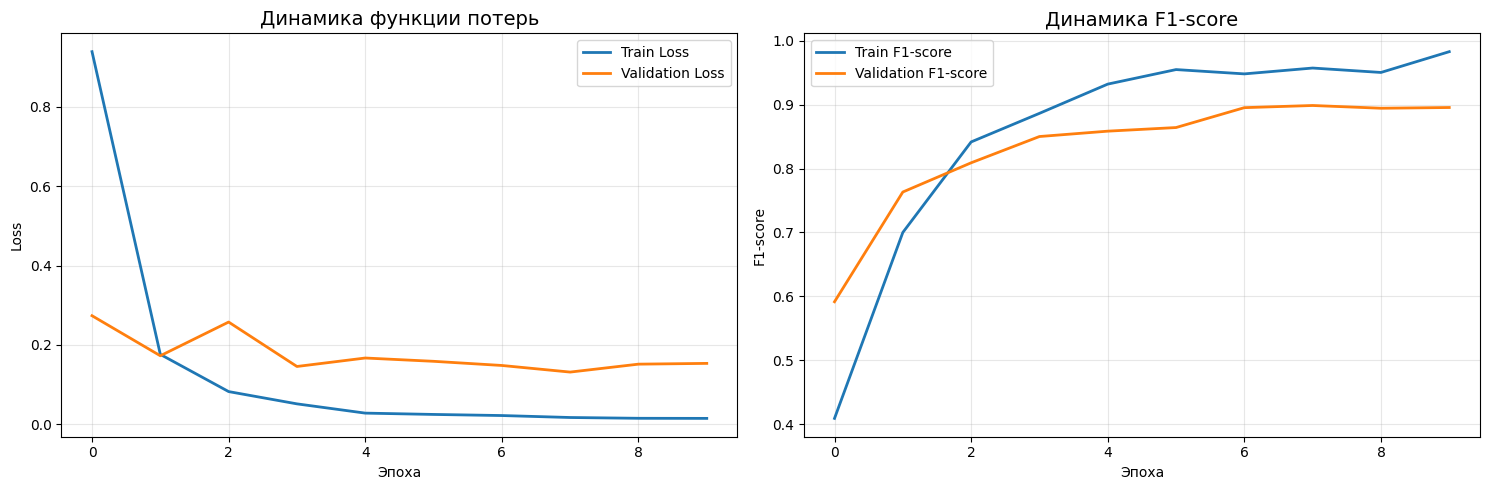


ФИНАЛЬНЫЕ МЕТРИКИ:
Лучший Train F1: 0.9828
Лучший Validation F1: 0.8986
Финальный Train Loss: 0.0150
Финальный Validation Loss: 0.1536


In [91]:
# Создаем график с двумя subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Loss
ax1.plot(results['train_losses'], label='Train Loss', linewidth=2)
ax1.plot(results['val_losses'], label='Validation Loss', linewidth=2)
ax1.set_title('Динамика функции потерь', fontsize=14)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График 2: F1-score
ax2.plot(results['train_f1_scores'], label='Train F1-score', linewidth=2)
ax2.plot(results['val_f1_scores'], label='Validation F1-score', linewidth=2)
ax2.set_title('Динамика F1-score', fontsize=14)
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('F1-score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим финальные метрики
print("\nФИНАЛЬНЫЕ МЕТРИКИ:")
print(f"Лучший Train F1: {max(results['train_f1_scores']):.4f}")
print(f"Лучший Validation F1: {max(results['val_f1_scores']):.4f}")
print(f"Финальный Train Loss: {results['train_losses'][-1]:.4f}")
print(f"Финальный Validation Loss: {results['val_losses'][-1]:.4f}")

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

In [92]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten(): # цикл повторяется (n_rows * n_cols) раз
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # выводим изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()

    # ниже представлен код для добавления на изображение подписи с вероятностью класса
    actual_text = "Actual : {}".format(img_label)


    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100 # берем максимальную вероятность класса
    y_pred = np.argmax(prob_pred) # берем числовую метку класса, для которого вероятность максимальна

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

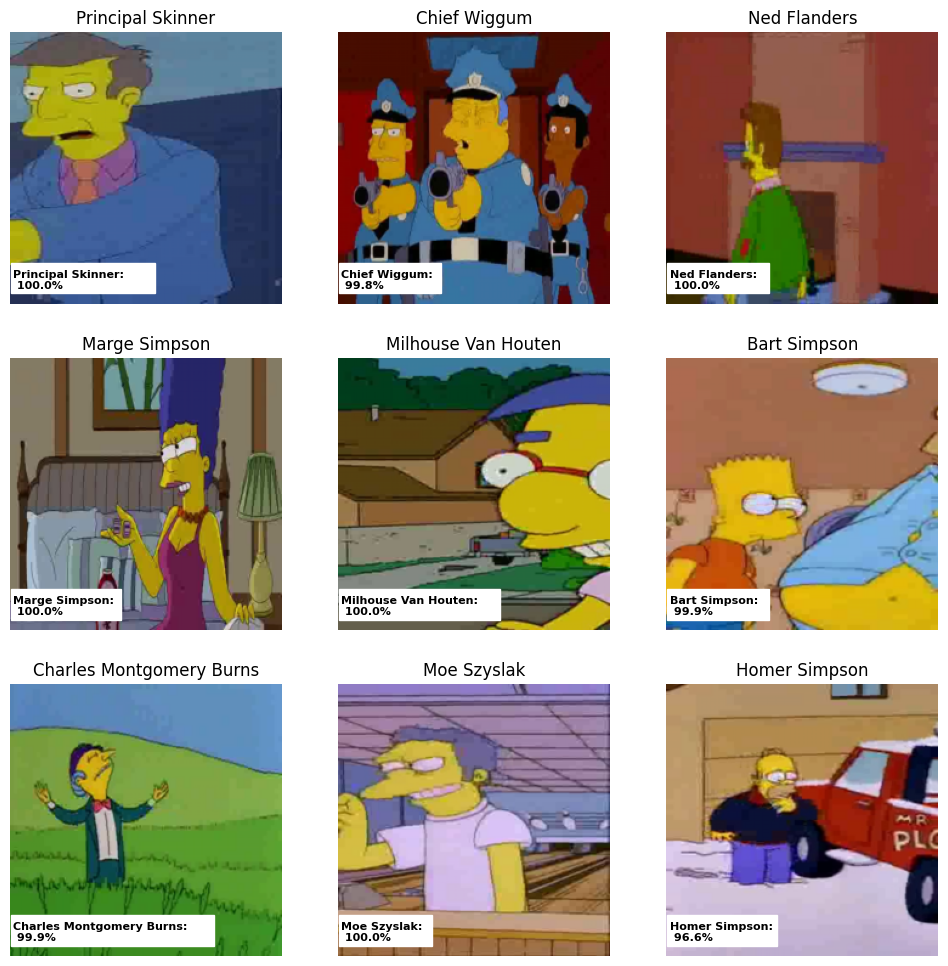

In [93]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = model)

In [94]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [95]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

In [97]:
predicted_numeric_labels = predict(model, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

In [98]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

In [100]:
import pandas as pd
sample_submission = pd.read_csv("/kaggle/working/sample_submission.csv")
sample_submission.head(10)

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson
5,img5.jpg,bart_simpson
6,img6.jpg,bart_simpson
7,img7.jpg,bart_simpson
8,img8.jpg,bart_simpson
9,img9.jpg,bart_simpson


In [101]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [102]:
my_submission.to_csv('simple_cnn_baseline.csv', index=False)

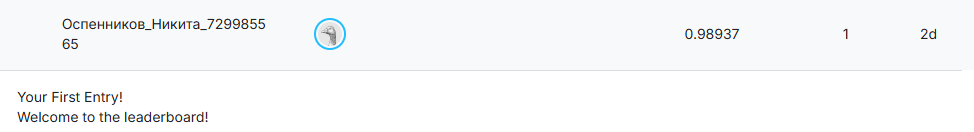